# Modelling

## Modelling Techniques

### Clustering

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dotenv import load_dotenv
import os

In [2]:
os.environ["OMP_NUM_THREADS"] = "1"   # OpenMP threads
os.environ["MKL_NUM_THREADS"] = "1"   # MKL’s own thread pool

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.sparse import coo_matrix, csr_matrix

In [4]:
import json
import numpy as np
import joblib

In [10]:
load_dotenv(".env")  # defaults to loading a `.env` file in the current directory

host = os.getenv("MY_SQL_HOST")
user = os.getenv("MY_SQL_USER")
password = os.getenv("MY_SQL_PASSWORD")
database = os.getenv("MY_SQL_DATABASE")

In [11]:
import mysql.connector

def get_connection(host, user, password, database):
    mydb = mysql.connector.connect(
      host=host,
      user=user,
      password=password,
      database=database
    )
    return mydb

In [12]:
connection = get_connection(host=host, user=user, password=password, database=database)

In [13]:
cursor = connection.cursor()

In [26]:
root_location = "E:\\applied data science capstone\\anime-recommendation\\modelling\\clustering\\exploration"

In [14]:
query = """
SELECT
    user_id,
    anime_id,
    rating
FROM
    rating_v2
ORDER BY
    user_id;
"""
cursor.execute(query)
raw_data = cursor.fetchall()

In [15]:
df = pd.DataFrame(raw_data, columns=["user_id", "anime_id", "rating"])

In [16]:
df["rating"] = pd.to_numeric(df["rating"])

In [6]:
filename = "E:\\applied data science capstone\\data\\etl\\extract\\transactions\\clustering_13_Jul.csv"

In [17]:
df.to_csv(filename, index=False)

In [18]:
df = pd.read_csv(filename)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47161882 entries, 0 to 47161881
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   anime_id  int64  
 2   rating    float64
dtypes: float64(1), int64(2)
memory usage: 1.1 GB


In [20]:
user_cat   = df['user_id'].astype('category')
anime_cat  = df['anime_id'].astype('category')

In [ ]:
# Re‑index users and movies to contiguous 0‑based indices
user_codes = user_cat.cat.codes
anime_codes = anime_cat.cat.codes
data = df['rating'].values

In [22]:
# Build COO, then convert to CSR (row‑compressed)
num_users  = user_codes.max() + 1
num_animes = anime_codes.max() + 1
user_item_sparse = coo_matrix((data, (user_codes, anime_codes)),
                              shape=(num_users, num_animes)).tocsr()

In [23]:
id_to_user = dict(enumerate(user_cat.cat.categories))   # {row → real userId}
id_to_anime = dict(enumerate(anime_cat.cat.categories))  # {col → real movieId}

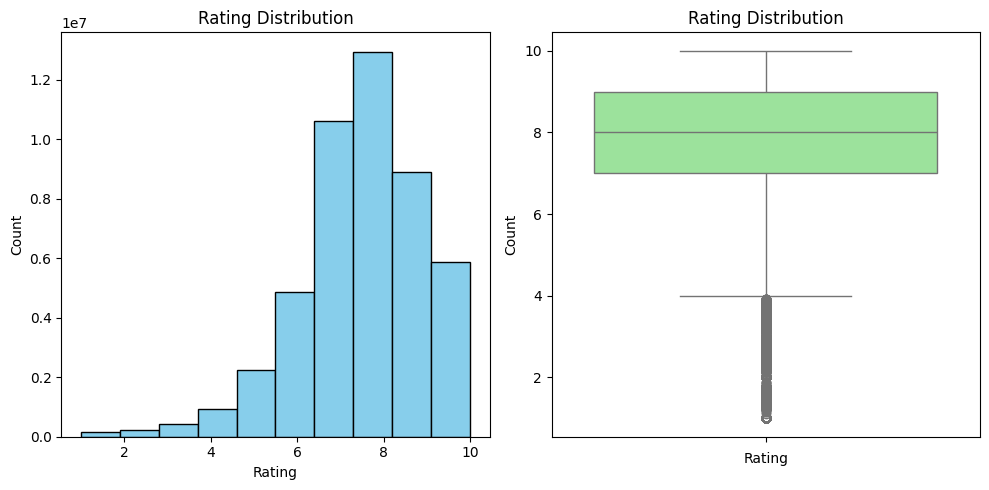

In [28]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(df['rating'], bins=10, color='skyblue', edgecolor='black')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.boxplot(data=df["rating"], color="lightgreen")
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(f"{root_location}\\plots\\ratings.png")
plt.show()

In [ ]:
max_k = 12

inertia = []
silhoutte_scores = []
k_values = range(2, max_k + 1)

for k in k_values:
    print(f"at stage {k}")
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)
    
    print("did k means")
    cluster_labels = kmeans.fit_predict(user_item_sparse)

    # print("did cluster predictions means")
    # sil_score = silhouette_score(user_item_sparse, cluster_labels)

    # print("did silhouette scores")
    # silhoutte_scores.append(sil_score)

    inertia.append(kmeans.inertia_)

at stage 2
did k means
at stage 3
did k means
at stage 4
did k means
at stage 5
did k means
at stage 6
did k means
at stage 7
did k means
at stage 8
did k means
at stage 9
did k means
at stage 10
did k means
at stage 11
did k means
at stage 12
did k means


<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

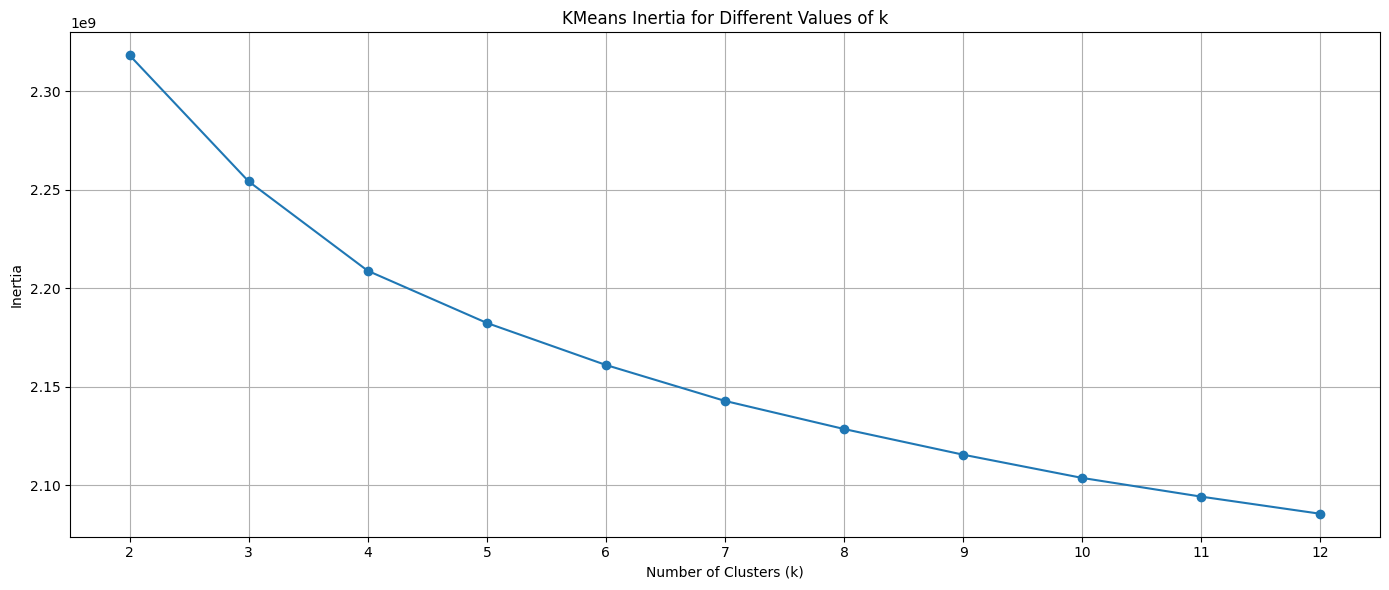

In [30]:
plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

# plt.subplot(1, 2, 2)
# plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
# plt.title('Silhouette Scores for Different Values of k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.xticks(k_values)
# plt.grid(True)

plt.tight_layout()
plt.savefig(f"{root_location}\\plots\\elbow_method_inertia.png")
plt.show()

In [32]:
kmeans = KMeans(n_clusters=4, random_state=42)
user_clusters = kmeans.fit_predict(user_item_sparse)

# Assign cluster labels back to users
clusters_df = pd.DataFrame({
    'user_id' : [id_to_user[i] for i in range(len(user_clusters))],
    'cluster': user_clusters
})

df_with_cluster = df.merge(clusters_df, on="user_id")

In [ ]:
model_bundle = {
    'kmeans': kmeans,
    'df': df_with_cluster,
    'id_to_user': id_to_user,
    'id_to_anime': id_to_anime
}

# Store to file
joblib.dump(model_bundle, "E:\\applied data science capstone\\clusters\\user_clustering_model_v1.joblib")

In [33]:
# Load everything
model_bundle = joblib.load("E:\\applied data science capstone\\clusters\\user_clustering_model_v1.joblib")

kmeans = model_bundle['kmeans']
df_with_cluster = model_bundle["df"]

sample_indices = np.random.choice(user_item_sparse.shape[0], size=3000, replace=False)
sample_matrix = user_item_sparse[sample_indices]
sample_labels = user_clusters[sample_indices]

e:\organized-anime-recommendation\organized-anime-recommendation\.venv\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [34]:
pca = PCA(n_components=2)
user_2d = pca.fit_transform(sample_matrix.toarray())

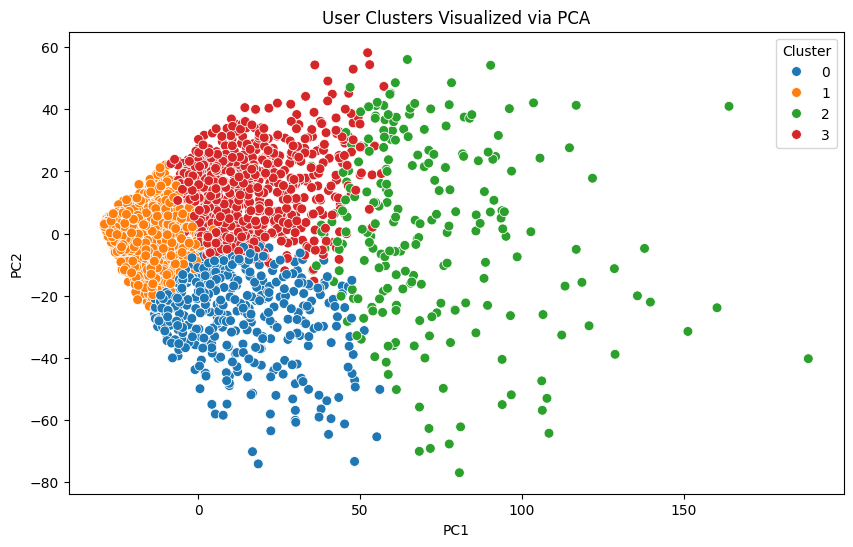

In [35]:
# Step 4: Plot
df_plot = pd.DataFrame({
    'x': user_2d[:, 0],
    'y': user_2d[:, 1],
    'cluster': sample_labels
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='x', y='y', hue='cluster', palette='tab10', s=50)
plt.title("User Clusters Visualized via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.savefig(f"{root_location}\\plots\\user_clusters.png")
plt.show()


### Topic Modelling

#### Load reviews data

In [41]:
from pymongo import MongoClient

def get_client(uri):
    client = MongoClient(uri)
    return client

In [ ]:
load_dotenv(".env")  # defaults to loading a `.env` file in the current directory

uri = os.getenv("MONGO_DB_URI")

client = get_client(uri)

In [43]:
database = client.get_database("anime_recommendation")
reviews = database.get_collection("reviews")
cursor = reviews.find()

In [45]:
data_lst = []
for item in cursor:
    for rev in item["reviews"]:
        data = {"anime_id": item["anime_id"], "review": rev["review"]}
        data_lst.append(data)

df = pd.DataFrame(data_lst)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201853 entries, 0 to 201852
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   anime_id  201853 non-null  int64 
 1   review    201853 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [73]:
df.isna().sum()

anime_id            0
review              0
processed_review    0
dtype: int64

#### Remove stopwords

In [75]:
texts = df['review'].tolist()
all_text = " ".join(texts).lower()

# remove punctuation and numbers
clean_text = re.sub(r"[^a-z\s]", "", all_text)

In [76]:
import os

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

import joblib

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

#These stop words are very generic and the list will need to be expanded to include those that are common in reviews and anime which would add no value
base_stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package punkt to C:\Users\Asus-
[nltk_data]     Home\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Asus-
[nltk_data]     Home\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to C:\Users\Asus-
[nltk_data]     Home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Asus-
[nltk_data]     Home\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [80]:
# tokenize
tokens = word_tokenize(clean_text)

# remove base stopwords
base_stopwords = set(stopwords.words('english'))
filtered_tokens = [word for word in tokens if word not in base_stopwords]


In [81]:
from collections import Counter

word_freq = Counter(filtered_tokens)

In [84]:
common_words = word_freq.most_common(50)
for word, count in common_words:
    print(f"{word}: {count}")

anime: 627349
characters: 477957
like: 425269
story: 409315
show: 400881
one: 355578
really: 317232
character: 314188
good: 272917
series: 259298
even: 223767
well: 217350
much: 210487
first: 205506
time: 201708
also: 193819
would: 185863
get: 167674
dont: 167551
watch: 164955
art: 160044
episode: 151561
season: 149087
way: 148409
main: 145186
plot: 141059
episodes: 135744
people: 133553
great: 133196
see: 129564
think: 125426
make: 125384
love: 123269
say: 122238
still: 121659
animation: 120306
something: 115659
lot: 115077
overall: 110429
pretty: 110204
many: 109146
watching: 108708
end: 107497
feel: 107130
im: 105222
world: 104374
could: 102387
know: 101675
life: 99464
doesnt: 99002


In [87]:
#add most frequent common words to stop words list
custom_anime_stop_words = set(word for word, count in common_words)
final_stop_words = base_stop_words.union(custom_anime_stop_words)

In [90]:
# used to store data to disk
def write_to_txt(filename, data):
    with open(filename, "w") as f:
        for word in sorted(data):
            f.write(word + "\n")
    print(f"file saved to {filename}")

def read_from_txt(filename):
    with open(filename, "r") as f:
        target = set(line.strip() for line in f if line.strip())
    print(f"contents read from {filename}")
    return target


In [89]:
write_to_txt("E:\\applied data science capstone\\topics\\stopwords\\v1.txt", final_stop_words)

file saved to E:\applied data science capstone\topics\stopwords\v1.txt


In [91]:
final_stop_words = read_from_txt("E:\\applied data science capstone\\topics\\stopwords\\v1.txt")

contents read from E:\applied data science capstone\topics\stopwords\v1.txt


#### Pre-processing

In [ ]:

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Asus-
[nltk_data]     Home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Asus-
[nltk_data]     Home\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [92]:
def preprocess(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    text = re.sub(r'(&quot;)', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in final_stop_words]
    return ' '.join(tokens)

In [93]:
df['processed_review'] = df['review'].apply(preprocess)

In [94]:
from textwrap import wrap

Let's see how the result of the preprocess step on the reviews

In [95]:
df.head()

,anime_id,review,processed_review
0,5,Cowboy Bebop: Knockin' on Heaven's Door is a g...,cowboy bebop knockin heaven door addition cowb...
1,5,I'm never that comfortable with films of serie...,never comfortable film mostly often film consi...
2,5,Cowboy Bebop: Knockin' on Heaven's Door was re...,cowboy bebop knockin heaven door released japa...
3,5,"It was a good follow up (in-between, actually)...",follow actually suggest youre planning cowboy ...
4,5,Warning : minor spoilers ahead It was a month ...,warning minor spoiler ahead month ago finished...


In [96]:
#wrap text to make it easier to read and see the effects of preprocessing
df["review"] = df["review"].apply(lambda x: "\n".join(wrap(x, width=180)))
df["processed_review"] = df["processed_review"].apply(lambda x: "\n".join(wrap(x, width=180)))

In [97]:
print(df.loc[0, "review"])

Cowboy Bebop: Knockin' on Heaven's Door is a great addition to the Cowboy Bebop series, but no more. It is by no means a sequel, and after watching it, I found that it's best
watched in the middle of the series, and not neccesarily at the end. If it's got a specific place or not, that I don't know, but that's not very important at any rate, and if
you've watched the entire series, it shouldn't be hard to mentally place it inside the series anyway. This time, a terrorist possesses a weapon capable of killing countless people,
and there's a bounty of 300 millionwoolongs on him; the largest bounty ever given. Of course, this means that our heroes will chase him. And so starts the process of gathering
information, meeting and getting to know people related to the bounty in some way, and eventually, squaring off against him in a final fight. Oh, and throw in a save-the-world
thing this time, and there you have the movie. Nothing really new, a formula that's been used several times. There's 

In [98]:
print(df.loc[0, "processed_review"])

cowboy bebop knockin heaven door addition cowboy bebop mean sequel found best watched middle neccesarily got specific place important rate watched entire hard mentally place inside
anyway terrorist possesses weapon capable killing countless bounty millionwoolongs largest bounty ever given course mean hero chase start process gathering information meeting
getting related bounty eventually squaring final fight oh throw save thing movie nothing new formula used several time detail left unexplained thing may happen reason rare occasion
minute might little long never came boring point certainly job fleshing minute though may credited movie threw interesting u orignal cast always probably got original movie example
vincent bad guy quite interesting fellow though help experienced type somewhat got mysterious past forgotten included going kill load reason blather sentence religion whatnot
nevertheless come interesting mostly similar spike physical prowess considering dead men due past event el

#### Training model

In [100]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, stop_words='english')
# Fit and transform the processed descriptions
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_review'])

In [101]:
# LSA reduces the dimensionality of the TF-IDF matrix while preserving semantic relationships.
# n_components determines the number of topics/latent dimensions.
num_topics = 100
lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_topic_matrix = lsa_model.fit_transform(tfidf_matrix)

#### Saving model

In [103]:
model_bundle = {
    'tfidf_matrix': tfidf_matrix,
    'df': df,
    'lsa_model': lsa_model,
    'tfidf_vectorizer': tfidf_vectorizer
}

In [104]:
joblib.dump(model_bundle, "E:\\applied data science capstone\\topics\\topic_model_v2.joblib")

['E:\\applied data science capstone\\topics\\topic_model_v2.joblib']

In [ ]:
model_bundle = joblib.load("E:\\applied data science capstone\\topics\\topic_model_v2.joblib")
df = model_bundle["df"]
lsa_model = model_bundle["lsa_model"]
tfidf_matrix = model_bundle["tfidf_matrix"]
tfidf_vectorizer = model_bundle["tfidf_vectorizer"]

#### Assessing Model

The recommendations to be made are textual and based on the reviews. The assessment of the model will therefore include:
1. Checking if the topics make sense
2. Manually inspecting some of the recommendations given based on the prompt. Domain specific knowledge about the anime titles will be used here.
3. Comparing the cosine similarity scores - if the graph is flat, the model sees everything as similar not good. If the graph clusters most values to the lower scores and tapers towards the higher scores this is good
as it recognizes the reviews which are most similar to the text given. If the graph has a lot of values closer to the higher values this indicates overfitting and results in bad recommendations

##### Topic Space Interpretability

In [102]:
# Display the top words for each topic
terms = tfidf_vectorizer.get_feature_names_out()
print("Top words for each LSA Topic:")
for i, comp in enumerate(lsa_model.components_):
    terms_in_comp = [(terms[j], comp[j]) for j in comp.argsort()[-10:][::-1]]
    print(f"Topic {i+1}: {', '.join([t[0] for t in terms_in_comp])}")
print("\n" + "="*50 + "\n")

Top words for each LSA Topic:
Topic 1: movie, thing, girl, scene, sound, bad, music, interesting, want, review
Topic 2: movie, film, ghibli, shinkai, hour, tv, minute, beautiful, original, scene
Topic 3: film, arc, manga, action, scene, fight, naruto, theme, viewer, work
Topic 4: film, girl, school, romance, cute, comedy, harem, slice, relationship, friend
Topic 5: game, mc, isekai, arc, fight, sao, kirito, power, hero, bad
Topic 6: manga, film, mc, girl, read, harem, isekai, bad, guy, adaptation
Topic 7: game, film, manga, sao, kirito, player, romance, video, online, play
Topic 8: que, la, en, el, se, lo, los, una, game, como
Topic 9: manga, girl, school, read, movie, adaptation, work, viewer, relationship, cast
Topic 10: arc, naruto, comedy, girl, filler, film, funny, romance, school, game
Topic 11: comedy, isekai, mc, romance, action, scene, harem, fun, genre, enjoyable
Topic 12: arc, romance, mc, sao, relationship, kirito, felt, clannad, second, feeling
Topic 13: naruto, isekai, mc

##### Relevance Consistency Check and Similarity Distribution Plot

In [170]:
def recommend_from_query_text(query_text, df_items, tfidf_vec, tfidf_matrix, lsa_model, num_recommendations=5):
    processed_query = preprocess(query_text)
    query_tfidf = tfidf_vec.transform([processed_query])
    query_lsa = lsa_model.transform(query_tfidf)

    similarities = cosine_similarity(query_lsa, lsa_model.transform(tfidf_matrix)).flatten()

    plt.hist(similarities, bins=50)
    plt.title("Similarity Score Distribution")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.show()

    top_indices = similarities.argsort()[-num_recommendations:][::-1]

    recommended_items = df_items.iloc[top_indices]
    recommended_items['similarity_score'] = similarities[top_indices]

    return recommended_items[['anime_id', 'review', "processed_review", 'similarity_score']]

In [145]:
# load anime df
anime_df = pd.read_csv("E:\\applied data science capstone\\data\\combined\\anime-for-db-27-Jun\\anime_list_27_Jun.csv")

In [197]:
# sample queries
query_1 = "action packed series about super powers"
query_2 = "romantic comedy about a high school couple"
query_3 = "a young boy pursuing his dream of playing sports"
query_4 = "people get trapped in a game they were playing"
query_5 = "science made to be fun and easy to learn"
query_6 = "cute girls doing cute stuff"
query_7 = "fast cars pulling off crazy stunts"
query_8 = "a whole lot of guns and shooting"
query_9 = "germophobe navigating life"
query_10 = "pop idols entertaining their fans"

1. action packed series about super powers

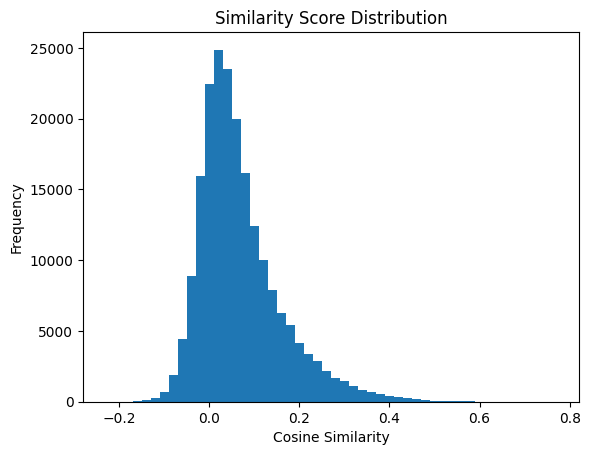

C:\Users\Asus-Home\AppData\Local\Temp\ipykernel_20432\122375758.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_items['similarity_score'] = similarities[top_indices]


In [179]:
recommendations_new_query = recommend_from_query_text(query_1, df, tfidf_vectorizer, tfidf_matrix, lsa_model, num_recommendations=10)

In [180]:
recommendations_new_query.head()

,anime_id,review,processed_review,similarity_score
410,6,"Without spoiling anything, I'll just say that ...",without spoiling anything probably surprise go...,0.771056
175042,40748,i've watched this anime twice and i'll still r...,watched twice every full action entertaining c...,0.762091
88567,16512,I am in love with this anime at the moment! Th...,moment use supernatural power easy fall line b...,0.742754
46429,4334,Ever thought of watching anime + marvel at the...,ever thought marvel collaboration stan lee stu...,0.720654
108021,25777,Every time I watch an episode of this series I...,every cant look away captivated loose basicall...,0.698470


In [181]:
recommendation_ids = set(recommendations_new_query["anime_id"].unique())
anime_df.loc[anime_df["anime_id"].isin(recommendation_ids), ["anime_id", "title", "synopsis"]]

,anime_id,title,synopsis
2,6,Trigun,"Vash the Stampede is the man with a $$60,000,0..."
46,68,Black Cat,"Completing every job with ruthless accuracy, T..."
599,957,The Story of Saiunkoku,"Shuurei Kou, the daughter of a noble yet impov..."
1029,1914,Tales of Saiunkoku,"Shuurei Kou and her friend Eigetsu To, a boy p..."
1693,3615,Neo Angelique Abyss,hile the young Angelique lives out her days pe...
1883,4334,Heroman,"In California's Center City, shy but kindheart..."
3270,16512,Devil Survivor 2 The Animation,The countdown to extinction begins on Sunday w...
3876,25777,Attack on Titan Season 2,"For centuries, humanity has been hunted by gia..."
4602,34542,Inuyashiki: Last Hero,Ichirou Inuyashiki is a 58-year-old family man...
5419,40748,Jujutsu Kaisen,Idly indulging in baseless paranormal activiti...


2. romantic comedy about a high school couple

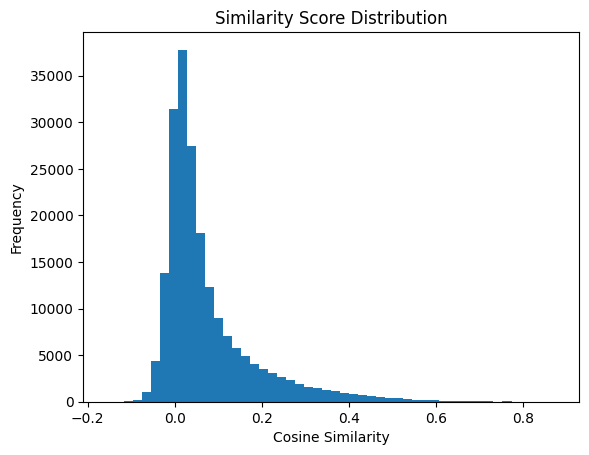

C:\Users\Asus-Home\AppData\Local\Temp\ipykernel_20432\122375758.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_items['similarity_score'] = similarities[top_indices]


In [182]:
recommendations_new_query = recommend_from_query_text(query_2, df, tfidf_vectorizer, tfidf_matrix, lsa_model, num_recommendations=10)

In [183]:
recommendations_new_query.head()

,anime_id,review,processed_review,similarity_score
5932,66,Well despite that Azumanga Daioh is about a st...,despite azumanga daioh friend attempt daily sc...,0.877907
2101,24,If you're looking for a documentary to sate yo...,looking documentary sate curiosity obscure phe...,0.860351
115888,30240,A prison gay review of Prison School Prison Sc...,prison gay review prison school prison school ...,0.853149
76408,11843,Unless you were incredibly popular during your...,unless incredibly popular school rule due webs...,0.846322
85806,14813,Yahari Ore no Seishun Love Comedy wa Machigatt...,yahari ore seishun comedy wa machigatteiru yah...,0.837718


In [184]:
recommendation_ids = set(recommendations_new_query["anime_id"].unique())
anime_df.loc[anime_df["anime_id"].isin(recommendation_ids), ["anime_id", "title", "synopsis"]]

,anime_id,title,synopsis
14,24,School Rumble,"Just the words ""I love you,"" and everything ch..."
44,66,Azumanga Daioh: The Animation,Chiyo Mihama begins her high school career as ...
522,853,Ouran High School Host Club,Haruhi Fujioka is a bright scholarship candida...
2267,6547,Angel Beats!,Otonashi awakens only to learn he is dead. A r...
2990,11843,Daily Lives of High School Boys,oaming the halls of the all-boys Sanada North ...
3169,14813,My Teen Romantic Comedy SNAFU,Hachiman Hikigaya is an apathetic high school ...
4079,30240,Prison School,"ocated on the outskirts of Tokyo, Hachimitsu P..."
4564,34281,High School DxD Hero,The fourth season of High School DxD .


3. a young boy pursuing his dream of playing sports

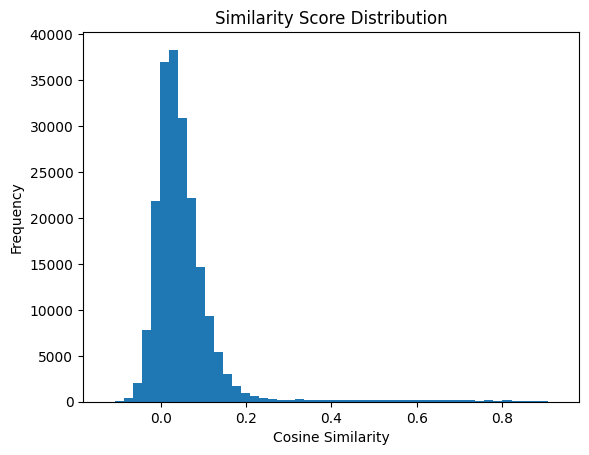

C:\Users\Asus-Home\AppData\Local\Temp\ipykernel_20432\122375758.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_items['similarity_score'] = similarities[top_indices]


In [185]:
recommendations_new_query = recommend_from_query_text(query_3, df, tfidf_vectorizer, tfidf_matrix, lsa_model, num_recommendations=10)

In [186]:
recommendations_new_query.head()

,anime_id,review,processed_review,similarity_score
182743,42395,Kabaddi is a contact team sport which involves...,kabaddi contact team sport involves material e...,0.927157
75163,11697,Another Sports anime added to my fave sports a...,another sport added fave sport list seems cool...,0.925690
156506,37965,I never really enjoyed any sports anime ever b...,never enjoyed sport ever reason never liked sp...,0.925670
186005,44274,First review just had to. First off Japan beat...,review japan beating team canada set tone hock...,0.921727
125629,32494,I think there's a lot of merit to judging an a...,merit judging tell show day football american ...,0.920485


In [187]:
recommendation_ids = set(recommendations_new_query["anime_id"].unique())
anime_df.loc[anime_df["anime_id"].isin(recommendation_ids), ["anime_id", "title", "synopsis"]]

,anime_id,title,synopsis
2969,11697,The Knight in the Area,Kakeru and Suguru are brothers who both have a...
3956,28391,Aokana: Four Rhythm Across the Blue,h the invention of anti-gravitational shoes kn...
4312,32494,Days,The series is about two boys named Tsukushi an...
5053,37965,Run with the Wind,"Former ace runner of Sendai Josei High School,..."
5565,42395,Burning Kabaddi,"First-year high schooler Tatsuya Yoigoshi, the..."
5585,42774,"Farewell, My Dear Cramer",h no soccer accomplishments to speak of during...
5658,44274,PuraOra! PRIDE OF ORANGE,"The story takes place in Nikko city, Tochigi P..."
5814,49052,Aoashi,"In a quiet rural town, the spotlight of a loca..."


4. people get trapped in a game they were playing

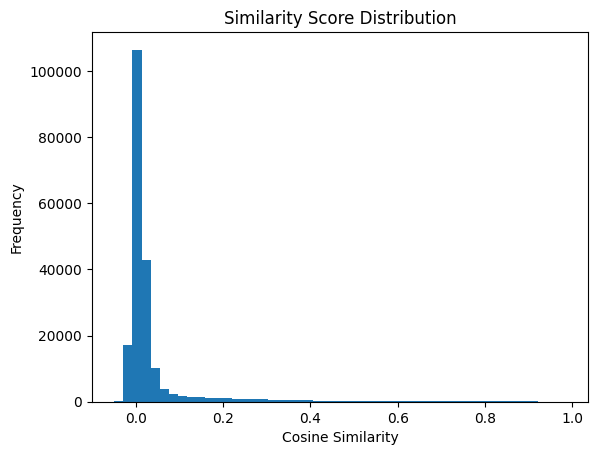

C:\Users\Asus-Home\AppData\Local\Temp\ipykernel_20432\122375758.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_items['similarity_score'] = similarities[top_indices]


In [188]:
recommendations_new_query = recommend_from_query_text(query_4, df, tfidf_vectorizer, tfidf_matrix, lsa_model, num_recommendations=10)

In [189]:
recommendations_new_query.head()

,anime_id,review,processed_review,similarity_score
182300,42307,Should you watch this instead of playing the g...,instead playing game hell game masterpiece spe...,0.984227
98202,21511,I can't belive this... They ruined it... It's ...,belive ruined kadokawa compane created though ...,0.978889
77109,11757,The story is great so far. Although following ...,far although following rule game contain const...,0.973301
189901,48441,If you've played and liked the Cold Steel seri...,played liked cold steel game appreciate game o...,0.972333
194455,50205,Arknights : Prelude to dawn is an anime adapta...,arknights prelude dawn adaptation game name ar...,0.969872


In [190]:
recommendation_ids = set(recommendations_new_query["anime_id"].unique())
anime_df.loc[anime_df["anime_id"].isin(recommendation_ids), ["anime_id", "title", "synopsis"]]

,anime_id,title,synopsis
2869,10588,Persona 4 the Animation,"Yuu Narukami moves to Inaba, a seemingly quiet..."
2978,11757,Sword Art Online,"In the year 2022, virtual reality has progress..."
3286,16592,Danganronpa: The Animation,Hope's Peak Academy is an elite high school th...
3535,19815,"No Game, No Life",No Game No Life is a surreal comedy that follo...
3661,21511,KanColle: Kantai Collection,h the seas under constant threat from the host...
3947,28223,Death Parade,"fter death, there is no heaven or hell, only a..."
5370,40403,Sakura Wars the Animation,"In 1930, two years after the events of So Long..."
5556,42307,The World Ends with You The Animation,"Neku Sakuraba, a 15-year-old boy with a hobby ..."
5759,48441,The Legend of Heroes: Trails of Cold Steel - N...,Eiyuu Densetsu: Sen no Kiseki centers around R...
5888,50205,Arknights Animation: Prelude to Dawn,The discovery of a black crystalline mineral k...


5. science made to be fun and easy to learn

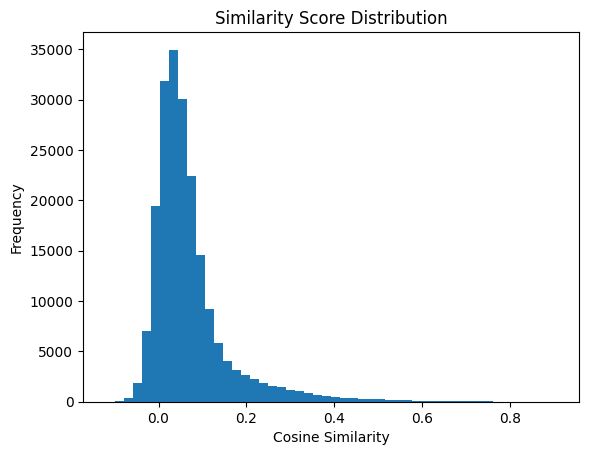

C:\Users\Asus-Home\AppData\Local\Temp\ipykernel_20432\122375758.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_items['similarity_score'] = similarities[top_indices]


In [191]:
recommendations_new_query = recommend_from_query_text(query_5, df, tfidf_vectorizer, tfidf_matrix, lsa_model, num_recommendations=10)

In [192]:
recommendations_new_query.head()

,anime_id,review,processed_review,similarity_score
123793,31953,This anime is just a delight to watch. Sure it...,delight sure remarkable revolutionize fun enjo...,0.906178
112884,28825,"This story is quite simple, this is a kid who ...",quite simple kid decides live double personali...,0.900556
176102,40852,Dr. Stone: Stone Wars is such a fun anime to w...,dr stone stone war fun continuation coming hyp...,0.892922
132892,33489,"This is a simple and fun show, one of those wi...",simple fun intention fun ride explain everythi...,0.886631
196000,49385,Kaijin Kaihatsu-bu no Kuroitsu-san (2022) This...,kaijin kaihatsu bu kuroitsu san fun expected e...,0.872348


In [193]:
recommendation_ids = set(recommendations_new_query["anime_id"].unique())
anime_df.loc[anime_df["anime_id"].isin(recommendation_ids), ["anime_id", "title", "synopsis"]]

,anime_id,title,synopsis
162,223,Dragon Ball,Gokuu Son is a young boy who lives in the wood...
2245,6347,Baka & Test - Summon the Beasts,Fumizuki Academy isn't a typical Japanese high...
3702,22147,Amagi Brilliant Park,"Seiya Kanie, a smart and extremely narcissisti..."
3941,28121,Is It Wrong to Try to Pick Up Girls in a Dungeon?,fe in the bustling city of Orario is never dul...
3982,28825,Himouto! Umaru-chan,"People are not always who they appear to be, a..."
4267,31953,New Game!,"Since childhood, Aoba Suzukaze has loved the F..."
4468,33489,Little Witch Academia,"""A believing heart is your magic!""—these were ..."
5434,40852,"Dr. Stone 2nd Season, Dr. Stone Second Season",Senkuu has made it his goal to bring back two ...
5599,42923,SK8 the Infinity,High school student Reki Kyan is passionate ab...
5833,49385,Miss Kuroitsu from the Monster Development Dep...,"On the outside, Agastia is a firm specializing..."


6. cute girls doing cute stuff

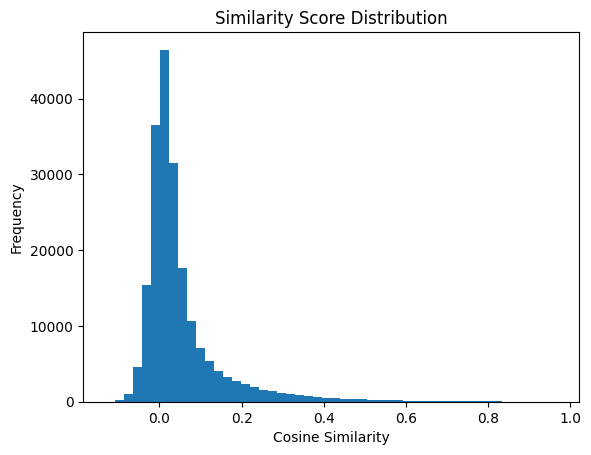

C:\Users\Asus-Home\AppData\Local\Temp\ipykernel_20432\122375758.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_items['similarity_score'] = similarities[top_indices]


In [198]:
recommendations_new_query = recommend_from_query_text(query_6, df, tfidf_vectorizer, tfidf_matrix, lsa_model, num_recommendations=10)

In [199]:
recommendations_new_query.head()

,anime_id,review,processed_review,similarity_score
52501,5680,K-On! is my comfort anime and it never fails t...,k comfort never fails smile definition definit...,0.966288
157726,37993,A lot of this reviewers are really quick to sa...,reviewer quick cosplay cute stuff loving shut ...,0.957362
91447,17549,A sweet and cute anime that just relaxing to w...,sweet cute relaxing want type girl likable sup...,0.954955
157750,37993,This show has yet again relit my flame for cut...,yet relit flame cute show cute girl absolutely...,0.930994
141486,35241,"""Cute fox girls doing cute things."" Konohana K...",cute fox girl cute thing konohana kitan litera...,0.926689


In [200]:
recommendation_ids = set(recommendations_new_query["anime_id"].unique())
anime_df.loc[anime_df["anime_id"].isin(recommendation_ids), ["anime_id", "title", "synopsis"]]

,anime_id,title,synopsis
2136,5680,K-ON!,fresh high school year always means much to co...
3138,14283,Vividred Operation,Friendship is the key to protecting the world....
3372,17549,Non Non Biyori,"sahigaoka might look like typical, boring coun..."
4371,32901,Eromanga Sensei,"One year ago, Sagiri Izumi became step-sibling..."
4694,35241,Konohana Kitan,"In a bustling village of spirits, Yuzu, a chee..."
5016,37704,Haifuri Movie,Yokosuka Girls' Marine High School is bustling...
5069,37993,WataTen! An Angel Flew Down to Me,College student Miyako Hoshino is quite shy ar...
5238,39324,"If It's for My Daughter, I'd Even Defeat a Dem...","Eighteen-year-old Dale Reki is a skilled, kind..."
5394,40571,Wandering Witch: The Journey of Elaina,"Since childhood, Elaina has always been fascin..."


7. fast cars pulling off crazy stunts

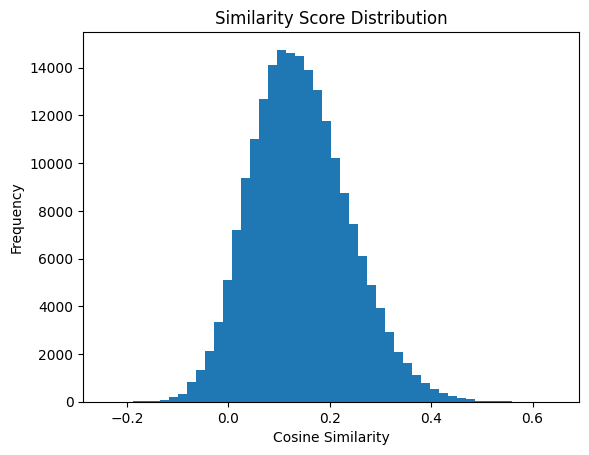

C:\Users\Asus-Home\AppData\Local\Temp\ipykernel_20432\122375758.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_items['similarity_score'] = similarities[top_indices]


In [201]:
recommendations_new_query = recommend_from_query_text(query_7, df, tfidf_vectorizer, tfidf_matrix, lsa_model, num_recommendations=10)

In [202]:
recommendations_new_query.head()

,anime_id,review,processed_review,similarity_score
55053,6675,FAST CARS! FAST CARS! FAST CARS! FAST CARS! FA...,fast car fast car fast car fast car fast car e...,0.647523
84312,14513,The story drags with barely any fighting scene...,drag barely fighting scene pacing painfully sl...,0.610955
24831,974,Dead Leaves....... How can I even describe thi...,dead leaf describe animated production g direc...,0.605487
93592,18679,"I usually never write reviews, but this anime ...",usually never write review thing right kind pa...,0.604848
191246,49387,I'm only at episode 5 and I'm frustrated. I lo...,frustrated loved vinland saga probably seen sa...,0.604649


In [203]:
recommendation_ids = set(recommendations_new_query["anime_id"].unique())
anime_df.loc[anime_df["anime_id"].isin(recommendation_ids), ["anime_id", "title", "synopsis"]]

,anime_id,title,synopsis
613,974,Dead Leaves,Pandy and Retro awaken naked on Earth with no ...
757,1292,Afro Samurai,"hen he was a young boy, Afro witnessed his fat..."
2288,6675,Redline,"Every five years, an exhilarating race called ..."
2354,7088,Demon King Daimao,"Dreaming of changing the world for good, Akuto..."
3151,14513,Magi: The Labyrinth of Magic,"Dispersed around the world, there are several ..."
3471,18679,Kill la Kill,"fter the murder of her father, Ryuuko Matoi ha..."
5732,47917,Bocchi the Rock!,Hitori Gotou is a high school girl who's start...
5834,49387,Vinland Saga Season 2,After his father's death and the destruction o...
5848,49596,Blue Lock,Yoichi Isagi was mere moments away from scorin...


8. a whole lot of guns and shooting

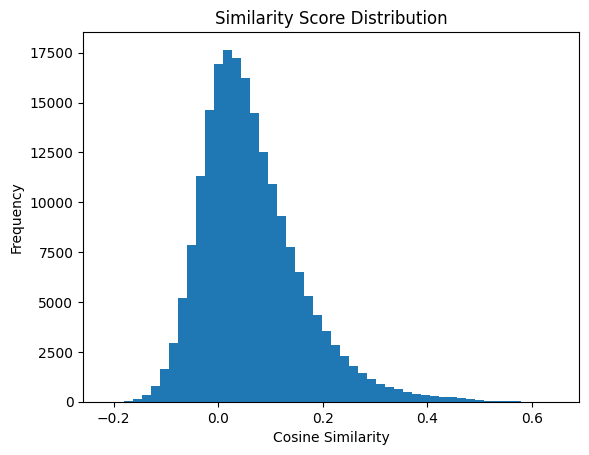

C:\Users\Asus-Home\AppData\Local\Temp\ipykernel_20432\122375758.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_items['similarity_score'] = similarities[top_indices]


In [204]:
recommendations_new_query = recommend_from_query_text(query_8, df, tfidf_vectorizer, tfidf_matrix, lsa_model, num_recommendations=10)

In [205]:
recommendations_new_query.head()

,anime_id,review,processed_review,similarity_score
188390,46604,A decent gun action anime. It's no Lycoris Rec...,decent gun action lycoris recoil sao sao alter...,0.647498
77850,11757,The main reason Sword Art Online gets a 10/10 ...,reason sword online get found kirito almost th...,0.628612
16857,411,Quentin Tarantino is one strange guy. His cult...,quentin tarantino strange guy cult film homage...,0.628402
54786,6594,"This is a show about swords, the title even ro...",sword title roughly translates sword sword swo...,0.626034
23877,889,Welcome back Studio Madhouse. The person chose...,welcome back studio madhouse person chosen dir...,0.614767


In [206]:
recommendation_ids = set(recommendations_new_query["anime_id"].unique())
anime_df.loc[anime_df["anime_id"].isin(recommendation_ids), ["anime_id", "title", "synopsis"]]

,anime_id,title,synopsis
293,411,Gun x Sword,"Van, a lanky and apathetic swordsman, is on a ..."
550,889,Black Lagoon,"hin Thailand is Roanapur, a depraved, crime-ri..."
757,1292,Afro Samurai,"hen he was a young boy, Afro witnessed his fat..."
2272,6594,Katanagatari,In an Edo-era Japan lush with a variety of swo...
2978,11757,Sword Art Online,"In the year 2022, virtual reality has progress..."
5282,39597,Sword Art Online: Alicization - War of Underworld,Despite the defeat of Quinella—the pontifex of...
5715,46604,Girls' Frontline,After World War III decimated the world's popu...


9. germophobe navigating life

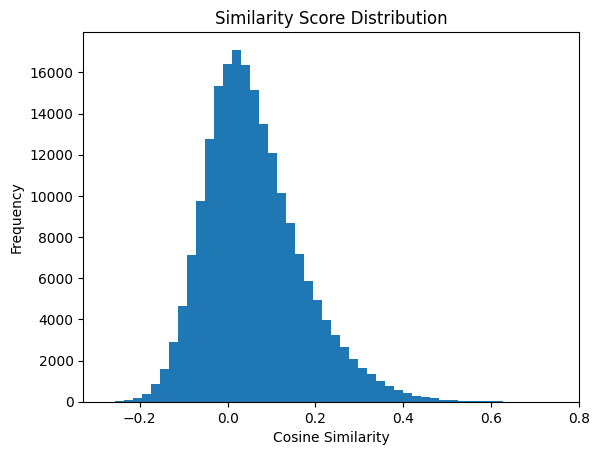

C:\Users\Asus-Home\AppData\Local\Temp\ipykernel_20432\122375758.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_items['similarity_score'] = similarities[top_indices]


In [207]:
recommendations_new_query = recommend_from_query_text(query_9, df, tfidf_vectorizer, tfidf_matrix, lsa_model, num_recommendations=10)

In [208]:
recommendations_new_query.head()

,anime_id,review,processed_review,similarity_score
193935,50425,"""More than a Married Couple, but Not Lovers"" i...",married couple lover captivating drama delf co...,0.749078
177370,40938,"""Higehiro: After Being Rejected, I Shaved and ...",higehiro rejected shaved took high school runa...,0.736836
184166,42897,Title: Horimiya - A Heartfelt Dive into Youthf...,title horimiya heartfelt dive youthful relatio...,0.731445
83454,14289,"Suki tte Ii na yo (Say ""I Love You"") - A Since...",suki tte ii na yo sincere relatable journey gr...,0.729850
193917,50425,"More than a Married Couple, but Not Lovers - A...",married couple lover bittersweet exploration r...,0.726310


In [209]:
recommendation_ids = set(recommendations_new_query["anime_id"].unique())
anime_df.loc[anime_df["anime_id"].isin(recommendation_ids), ["anime_id", "title", "synopsis"]]

,anime_id,title,synopsis
3139,14289,"Say ""I Love You.""",Friends will only let you down—that is the sad...
3244,16067,A Lull in the Sea,"ong ago, all humans lived beneath the sea. How..."
4485,33654,Hitorijime My Hero,asahiro Setagawa is a hopeless teenager who is...
4807,36220,Our love has always been 10 centimeters apart.,ou Aida and Haruki Serizawa might seem like po...
5450,40938,"Higehiro: After Being Rejected, I Shaved and T...",Office worker Yoshida has been crushing on his...
5595,42897,Horimiya,"On the surface, the thought of Kyouko Hori and..."
5708,46352,Blue Period,Second-year high school student Yatora Yaguchi...
5908,50425,"More than a married couple, but not lovers.",Third-year high school student Jirou Yakuin is...
6017,52578,The Dangers in My Heart,Kyoutarou Ichikawa may look like a shy and res...


10. pop idols entertaining their fans

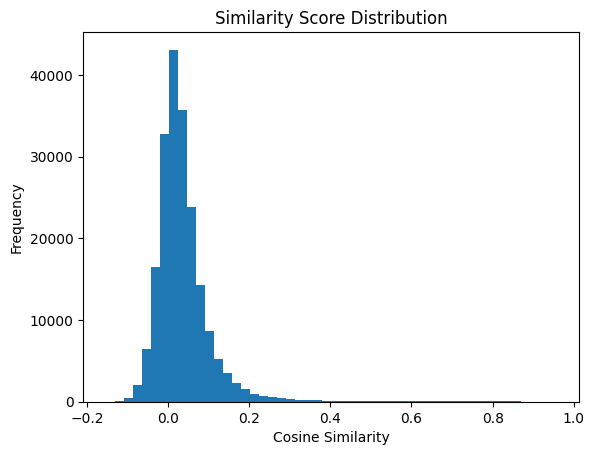

C:\Users\Asus-Home\AppData\Local\Temp\ipykernel_20432\122375758.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_items['similarity_score'] = similarities[top_indices]


In [210]:
recommendations_new_query = recommend_from_query_text(query_10, df, tfidf_vectorizer, tfidf_matrix, lsa_model, num_recommendations=10)

In [211]:
recommendations_new_query.head()

,anime_id,review,processed_review,similarity_score
156319,37890,At the start of the season I saw a new Idol an...,start saw new idol airing another maybe downlo...,0.957675
156313,37890,"It's unique, that's why it's awesome. Most of ...",unique awesome idol idol star group girl dream...,0.949029
198483,49692,Heroines Run the Show is an interesting look a...,heroine run interesting look idol culture lens...,0.933319
191474,52034,To follow non-idol fans... I don't like idol a...,follow non idol fan idol honest despise idol c...,0.917976
156327,37890,Don't let the poster fool you: this is not an ...,let poster fool idol comedy idol fan culture a...,0.912640


In [212]:
recommendation_ids = set(recommendations_new_query["anime_id"].unique())
anime_df.loc[anime_df["anime_id"].isin(recommendation_ids), ["anime_id", "title", "synopsis"]]

,anime_id,title,synopsis
3013,12149,AKB0048,fter an interplanetary war at the beginning of...
5043,37890,If My Favorite Pop Idol Made It to the Budokan...,"girl is obsessed with her favorite idol, a min..."
5059,37976,Zombie Land Saga,Sakura Minamoto dreams of becoming an idol. Un...
5283,39609,Dropout Idol Fruit Tart,Fourth dormitory of the Rat Production (common...
5852,49692,Heroines Run the Show: The Unpopular Girl and ...,"Freshly graduating middle school, energetic 15..."
5996,52034,[Oshi No Ko],"In the entertainment world, celebrities often ..."


##### Similarity Distribution

In [213]:
def plot_multiquery_similarity_distribution(query_texts, tfidf_vec, tfidf_matrix, lsa_model, bins=50):
    all_similarities = []

    for query in query_texts:
        # Preprocess and transform query
        processed_query = preprocess(query)
        query_tfidf = tfidf_vec.transform([processed_query])
        query_lsa = lsa_model.transform(query_tfidf)
        
        # Compute similarities with all items
        sims = cosine_similarity(query_lsa, lsa_model.transform(tfidf_matrix)).flatten()
        all_similarities.append(sims)

    # Convert to numpy array for averaging
    all_similarities = np.array(all_similarities)

    # Flatten for combined histogram
    flat_sims = all_similarities.flatten()

    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(flat_sims, bins=bins, color='lightcoral', edgecolor='black', alpha=0.7)
    plt.title("Multi-Query Similarity Score Distribution")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.show()

    # Optionally plot average similarity curve across bins
    bin_counts, bin_edges = np.histogram(flat_sims, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    avg_counts = bin_counts / len(query_texts)

    plt.figure(figsize=(8, 5))
    plt.plot(bin_centers, avg_counts, marker='o', color='blue')
    plt.title("Average Similarity Distribution Across Queries")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Average Frequency per Query")
    plt.grid(True)
    plt.show()


The model performs well over a diverse set of prompts as evidenced by the cluster of similarities around the lower scores and a tail towards the higher similarity scores.  
The curve shows that the average similarities peak around the lower scores.

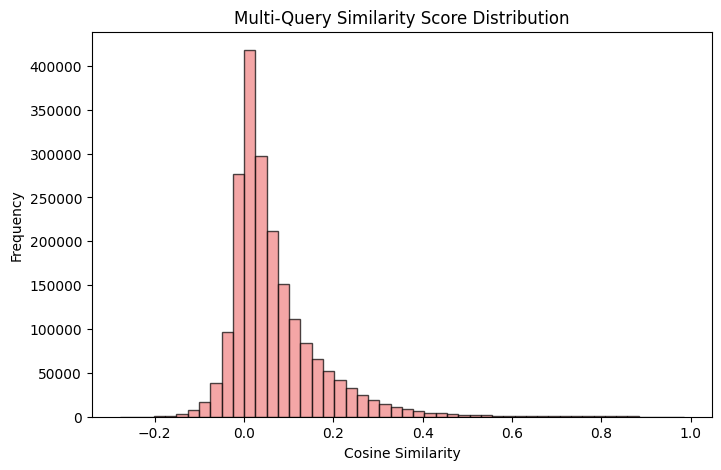

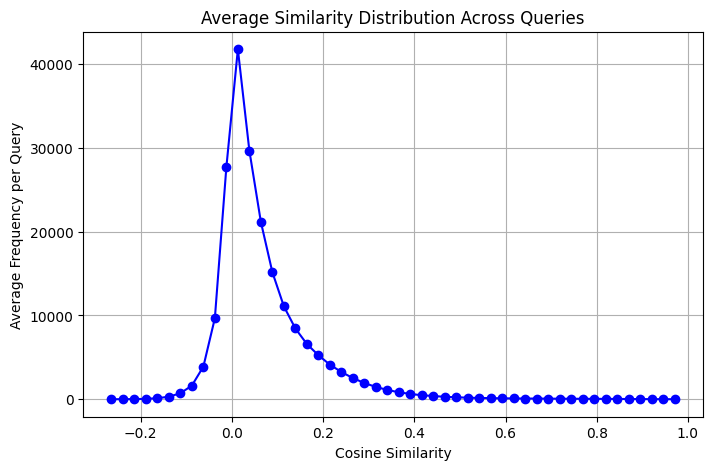

In [214]:
sample_queries = [query_1, query_2, query_3, query_4, query_5, query_6, query_7, query_8, query_9, query_10]
plot_multiquery_similarity_distribution(sample_queries, tfidf_vectorizer, tfidf_matrix, lsa_model)

#### Evaluation